In [4]:
import numpy as np
import pickle 
import torch
import torch.utils.data as data
from sklearn.datasets import make_moons
import torch.nn as nn
from torch.distributions.uniform import Uniform

In [5]:
n_channel = 1

In [6]:
class WeightNormConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)

In [7]:
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, 1, stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, 3, stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, 1, stride=1, padding=0),
        )

    def forward(self, x):
        return x + self.block(x)


class ResNet(nn.Module):
    def __init__(self, in_channel=n_channel, out_channel=2 * n_channel, intermediate_channel=128, num_blocks=8):
        super(ResNet, self).__init__()
        layers = [WeightNormConv2d(in_channel, intermediate_channel, 3, stride=1, padding=1), nn.ReLU()]
        for _ in range(num_blocks):
            layers.append( ResNetBlock(intermediate_channel) )
        layers.append(nn.ReLU())
        layers.append( WeightNormConv2d(intermediate_channel, out_channel, 3, stride=1, padding=1) )

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [8]:
class Preprocess(nn.Module):
    def __init__(self):
        super(Preprocess, self).__init__()

    def forward(self, x, reverse=False):
        device = x.device
        if reverse:
            return (x.sigmoid() - 0.05) / 0.9
        x += Uniform(0.0, 1.0).sample(x.size()).to(device)
        x = 0.05 + 0.9 * (x / 4.0)
        z = torch.log(x) - torch.log(1-x)
        log_det_jacobian = -x.log() - (1-x).log() + torch.tensor(0.9/4).log().to(device)
        return z, log_det_jacobian

In [9]:
class AffineCheckerboardTransform(nn.Module):
    def __init__(self, height, width, top_left_zero=False):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = self.create_mask(height, width, top_left_zero)
        self.scale_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = ResNet()
    
    def create_mask(self, height, width, top_left_zero):
        mask = (torch.arange(height).view(-1,1) + torch.arange(width))
        if not top_left_zero:
            mask += 1
        return (mask % 2).unsqueeze(0).unsqueeze(0)

    def forward(self, x, reverse=False):
        self.mask = self.mask.to(x.device)
        x_masked = x * self.mask
        log_scale, shift = self.net(x_masked).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale
        log_scale = log_scale * (1-self.mask)
        shift = shift * (1-self.mask)

        if reverse: 
            x= (x-shift) * torch.exp(-log_scale)
            return x
        else:
            x = x * log_scale.exp() + shift
            return x, log_scale

In [10]:
class AffineChannelwiseTransform(nn.Module):
    def __init__(self, top_half_as_input):
        super(AffineChannelwiseTransform, self).__init__()
        self.top_half_as_input = top_half_as_input
        self.scale_scale =  nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = ResNet(in_channel=2 * n_channel, out_channel=4 * n_channel)

    def forward(self, x, reverse=False):
        # x.size() is (batch_size, 4, H//2, W//2)
        # fixed, not_fixed have size (batch_size, 2, H//2, W//2)
        if self.top_half_as_input:
            fixed, not_fixed = x.chunk(2, dim=1)
        else:
            not_fixed, fixed = x.chunk(2, dim=1)
        log_scale, shift = self.net(fixed).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale
        if reverse:
            not_fixed = (not_fixed - shift) * torch.exp(-log_scale)
        else:
            not_fixed = not_fixed * log_scale.exp() + shift
        
        if self.top_half_as_input:
            x_modified = torch.cat([fixed, not_fixed], dim=1)
            log_scale = torch.cat([log_scale, torch.zeros_like(log_scale)], dim=1)
        else:
            x_modified = torch.cat([not_fixed, fixed], dim=1)
            log_scale = torch.cat([torch.zeros_like(log_scale), log_scale], dim=1)
        
        if reverse:
            return x_modified
        return x_modified, log_scale


In [11]:
class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale)
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = -torch.log(torch.std(x, [0,2,3], keepdim=True))
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

In [12]:
class RealNVP(nn.Module):
    def __init__(self, height, width, n_channels=n_channel):
        super(RealNVP, self).__init__()
        self.preprocess = Preprocess()
        self.transforms_checkered_1 = nn.ModuleList([
            AffineCheckerboardTransform(height, width, False),
            ActNorm(n_channels),
            AffineCheckerboardTransform(height, width, True),
            ActNorm(n_channels),
            AffineCheckerboardTransform(height, width, False),
            ActNorm(n_channels),
            AffineCheckerboardTransform(height, width, True)
        ])

        self.transforms_channelwise = nn.ModuleList([
            AffineChannelwiseTransform(True),
            ActNorm(4 * n_channels),
            AffineChannelwiseTransform(False),
            ActNorm(4* n_channels),
            AffineChannelwiseTransform(True),
        ])

        self.transforms_checkered_2 = nn.ModuleList([
            AffineCheckerboardTransform(height, width, False),
            ActNorm(n_channels),
            AffineCheckerboardTransform(height, width, True),
            ActNorm(n_channels),
            AffineCheckerboardTransform(height, width, False)
        ])

    def squeeze(self, x):
        '''converts a (batch_size,1,4,4) tensor into a (batch_size,4,2,2) tensor'''
        batch_size, num_channels, height, width = x.size()
        x = x.reshape(batch_size, num_channels, height//2, 2, width//2, 2)
        x = x.permute(0,1,3,5,2,4)
        x = x.reshape(batch_size, num_channels*4, height//2, width//2)
        return x

    def unsqueeze(self, x):
        '''converts a (batch_size,4,2,2) tensor into a (batch_size,1,4,4) tensor'''
        batch_size, num_channels, height, width = x.size()
        x = x.reshape(batch_size, num_channels//4, 2, 2, height, width)
        x = x.permute(0,1,4,2,5,3)
        x = x.reshape(batch_size, num_channels//4, height*2, width*2)
        return x

    def forward(self, x):
        z, log_det_jacobian_total = x, torch.zeros_like(x)
        
        z, log_det_jacobian = self.preprocess(z)
        log_det_jacobian_total += log_det_jacobian

        for transform in self.transforms_checkered_1:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        z = self.squeeze(z)
        log_det_jacobian_total = self.squeeze(log_det_jacobian_total)

        for transform in self.transforms_channelwise:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        z = self.unsqueeze(z)
        log_det_jacobian_total = self.unsqueeze(log_det_jacobian_total)

        for transform in self.transforms_checkered_2:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        return z, log_det_jacobian_total

    def inverse(self, z):
        x = z
        for transform in self.transforms_checkered_2[::-1]:
            x = transform(x, reverse=True)
        x = self.squeeze(x)
        for transform in self.transforms_channelwise[::-1]:
            x = transform(x, reverse=True)
        x = self.unsqueeze(x)
        for transform in self.transforms_checkered_1[::-1]:
            x = transform(x, reverse=True)
        x = self.preprocess(x, reverse=True)

        return x        

In [13]:
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

In [14]:
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", train=True, download=True, transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", train=False, download=True, transform = transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



In [15]:
train_dataset_list = []
for data in train_dataset:
    if data[1] == 9:
        train_dataset_list.append(data[0])
train_dataset = np.array(train_dataset_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [16]:
test_dataset_list = []
for data in test_dataset:
    if data[1] == 9:
        test_dataset_list.append(data[0])
test_dataset = np.array(test_dataset_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [17]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=32, shuffle=False)

In [18]:
for X_train in train_loader:
    print('X_train:', X_train.size(), X_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) torch.FloatTensor


In [19]:
INPUT_H, INPUT_W = 28, 28

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def loss_function(target_distribution, z, log_det_jacobian):
    log_likelihood = target_distribution.log_prob(z) + log_det_jacobian
    return -log_likelihood.mean()

def train(model, train_loader, optimizer, target_distribution):
    model.train()
    for i, x in enumerate(train_loader):
        x = x.to(device)
        z, log_dz_by_dx = model(x)
        loss = loss_function(target_distribution, z, log_dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100 == 0: print('Loss at iteration {} is {}'.format(i, loss.cpu().item()))

def eval_loss(model, data_loader, target_distribution):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            z, log_dz_by_dx = model(x)
            loss = loss_function(target_distribution, z, log_dz_by_dx)
            total_loss += loss * x.size(0)
    return (total_loss / len(data_loader.dataset)).cpu().item()

def train_and_eval(flow, epochs, lr, train_loader, test_loader, target_distribution):
    print('no of parameters is', sum(param.numel() for param in flow.parameters()))
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        print('Starting epoch:', epoch+1, 'of', epochs)
        train(flow, train_loader, optimizer, target_distribution)
        train_losses.append(eval_loss(flow, train_loader, target_distribution))
        test_losses.append(eval_loss(flow, test_loader, target_distribution))
    return flow, train_losses, test_losses

if __name__ == '__main__':
    print('Device is:', device)
    from torch.distributions.normal import Normal
    flow = RealNVP(INPUT_H, INPUT_W).to(device)
    target_distribution = Normal(torch.tensor(0).float().to(device),torch.tensor(1).float().to(device))
    flow, train_losses, test_losses = train_and_eval(flow, 10, 5e-4, train_loader, test_loader, target_distribution)
    print('train losses are', train_losses)
    print('test losses are', test_losses)
    torch.save(flow.state_dict(), 'trained_weights.pt')

Device is: cuda
no of parameters is 14526946
Starting epoch: 1 of 10
Loss at iteration 0 is 0.5871239304542542
Loss at iteration 100 is 0.3501273989677429
Starting epoch: 2 of 10
Loss at iteration 0 is 0.30508720874786377
Loss at iteration 100 is 0.2638406455516815
Starting epoch: 3 of 10
Loss at iteration 0 is 0.2494489997625351
Loss at iteration 100 is 0.2370213270187378
Starting epoch: 4 of 10
Loss at iteration 0 is 0.22538070380687714
Loss at iteration 100 is 0.22988104820251465
Starting epoch: 5 of 10
Loss at iteration 0 is 0.21769078075885773
Loss at iteration 100 is 0.21703454852104187
Starting epoch: 6 of 10
Loss at iteration 0 is 0.20625880360603333
Loss at iteration 100 is 0.20350266993045807
Starting epoch: 7 of 10
Loss at iteration 0 is 0.1987028270959854
Loss at iteration 100 is 0.20640049874782562
Starting epoch: 8 of 10
Loss at iteration 0 is 0.19220834970474243
Loss at iteration 100 is 0.1948031783103943
Starting epoch: 9 of 10
Loss at iteration 0 is 0.19858527183532715

In [21]:
z = torch.distributions.normal.Normal(0.0, 1.0).sample([10,1,28,28])
z = z.to(device)
with torch.no_grad():
    x = flow.inverse(z)
x = x.permute(0,2,3,1).squeeze().cpu().numpy()

In [22]:
def min_max_normalize(x):
    return (x-x.min())/(x.max()-x.min())

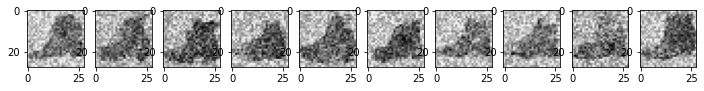

In [23]:
fig, axes = plt.subplots(1,10,figsize=(12,3))
for i in range(10):
    data = min_max_normalize(x[i])
    axes[i].imshow(data, cmap = "gray_r")

Reference: https://github.com/TinyVolt/normalizing-flows/tree/main/realnvp_images
